In [1]:
import sys
sys.path.append(sys.path[0]+"/../")
import h5py
import pybind_kernels.histograms as histograms
import pybind_kernels.label as label
import numpy as np
from config.paths import binary_root, hdf5_root_fast as hdf5_root
from tqdm import tqdm
from scipy import ndimage as ndi
import timeit
from PIL import Image
import matplotlib.pyplot as plt
NA = np.newaxis

def sphere(n):
    xs = np.linspace(-1,1,n)
    return (xs[:,NA,NA]**2 + xs[NA,:,NA]**2 + xs[NA,NA,:]**2) <= 1


# TODO commandline arguments
scale = 8
sample = '770c_pag'
verify_ndi = True
output_dir = 'aoeu'

#with np.load(f"{binary_root}/masks/implant/{scale}x/{sample}.npz") as f:
#    implant_mask = f['implant_mask'][:,:,:]

implant_mask = np.zeros((200,200,200), dtype=np.uint8)

implant_mask[:,80:120,80:120] = True
implant_mask[80:120,:,80:120] = True
implant_mask[80:120,80:120,:] = True

nz, ny, nx = implant_mask.shape

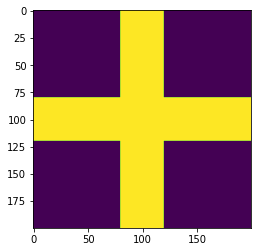

In [2]:
plt.imshow(implant_mask[:,100,:])

In [3]:
voxels = implant_mask.astype(np.uint8)
cpu_result = np.empty_like(voxels)
cpu_start = timeit.default_timer()
histograms.dilate_3d_sphere_cpu(voxels, 10, cpu_result)
cpu_end = timeit.default_timer()
cpu_time = cpu_end - cpu_start
print (f'cpu did it in {cpu_time} seconds')

cpu did it in 5.5420195430051535 seconds


{0, 1}

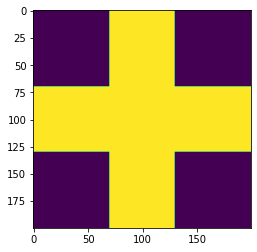

In [4]:
plt.imshow(cpu_result[:,100,:])
set(cpu_result.flatten())

In [5]:
gpu_result = np.empty_like(voxels)
gpu_start = timeit.default_timer()
histograms.dilate_3d_sphere_gpu(voxels, 10, gpu_result)
gpu_end = timeit.default_timer()
gpu_time = gpu_end - gpu_start;
print (f'gpu did it in {gpu_time} seconds')

gpu did it in 0.3148805829696357 seconds


In [15]:
sph = sphere(10)
ndi_start = timeit.default_timer()
ndi_result = ndi.binary_dilation(voxels, sphere(21))
ndi_end = timeit.default_timer()
ndi_time = ndi_end - ndi_start
print (f'ndi did it in {ndi_time}')

ndi did it in 21.587946378975175


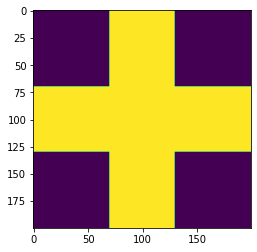

In [16]:
plt.imshow(ndi_result[:,100,:])

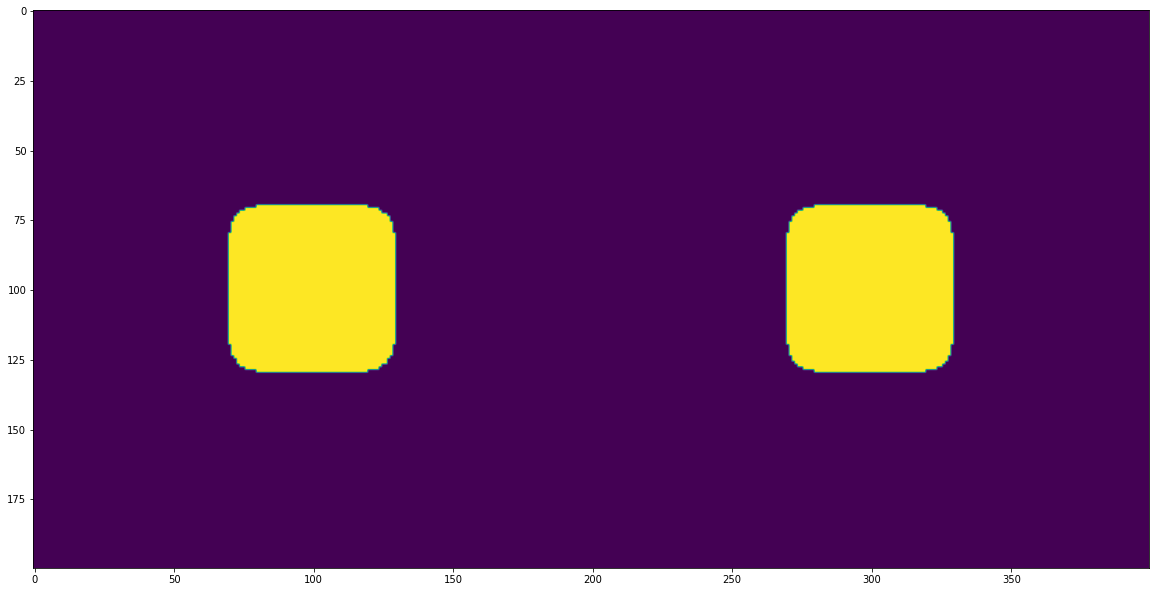

In [27]:
plt.figure(figsize=(20,200))
plt.imshow(np.hstack([ndi_result[:,10,:],gpu_result[:,10,:], ndi_result[:,10,:] - gpu_result[:,10,:]]))

In [19]:
print (f'speedup ndi vs cpu - {ndi_time / cpu_time:.2f}')
print (f'speedup ndi vs gpu - {ndi_time / gpu_time:.2f}')
print (f'speedup cpu vs gpu - {cpu_time / gpu_time:.2f}')

if not np.allclose(cpu_result, ndi_result): print ('!!!!! cpu version did not match ndimage !!!!!')
if not np.allclose(gpu_result, ndi_result): print ('!!!!! gpu version did not match ndimage !!!!!')
if not np.allclose(cpu_result, gpu_result): print ('!!!!! CPU AND GPU DID NOT MATCH !?!?!? !!!!!')

Image.fromarray((cpu_result[nz//2,:,:])).save(f'{output_dir}/cpu-{sample}-xy.png')
Image.fromarray((cpu_result[:,ny//2,:])).save(f'{output_dir}/cpu-{sample}-xz.png')
Image.fromarray((cpu_result[:,:,nx//2])).save(f'{output_dir}/cpu-{sample}-yz.png')

speedup ndi vs cpu - 3.90
speedup ndi vs gpu - 68.56
speedup cpu vs gpu - 17.60
!!!!! cpu version did not match ndimage !!!!!
!!!!! gpu version did not match ndimage !!!!!
